In [2]:
import os
import pandas as pd

# Sets the path to the parent directory of RR classes
os.chdir("C:\\Users\\leski\\OneDrive\\Pulpit\\DS\\IV SEM\\RR\\repositories\\RRcourse2023\\6. Coding and documentation")

# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv("Data\\onet_tasks.csv")
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)

for x in range(1,10):
     globals()["isco"+str(x)] = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO"+str(x))

# We will focus on three countries, but perhaps we could clean this code to allow it
# to easily run for all the countries in the sample?

# This will calculate worker totals in each of the chosen countries.
countries =  ['Belgium', 'Spain', 'Poland']
for country in countries:
    globals()["total_"+country] = 0
    for x in range(1,10):
        globals()["total_"+country] += globals()["isco"+str(x)][country]


In [3]:

all_data = pd.DataFrame()
for x in range(1, 10):
    sheet_name = f"ISCO{x}"
    df = pd.read_excel("Data//Eurostat_employment_isco.xlsx", sheet_name=sheet_name)
    df['ISCO'] = x
    all_data = pd.concat([all_data, df], ignore_index=True)
    
totals_set = {}
for country in all_data.columns[2:]:
    totals_set[country] = all_data[country].sum()

for country, total in totals_set.items():
    all_data[f"total_{country}"] = total
    all_data[f"share_{country}"] = all_data[country] / total


In [4]:
# Now let's look at the task data. We want the first digit of the ISCO variable only
import pandas as pd
import numpy as np
import re

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:



In [6]:
from scipy.stats import gmean

countries = ["Belgium", "Poland", "Spain"]
features = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]

for feature in features:
    for country in countries:
        col_name = f"std_{country}_{feature}"
        temp_mean = gmean(combined[feature])
        temp_sd = np.sqrt(np.average((combined[feature]-temp_mean)**2, weights=combined[f"share_{country}"]))
        combined[col_name] = (combined[feature]-temp_mean)/temp_sd


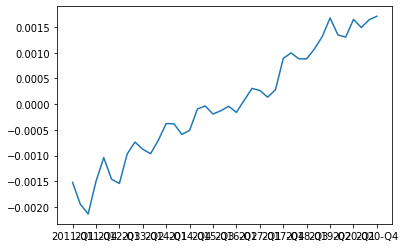

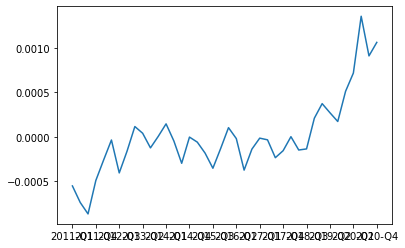

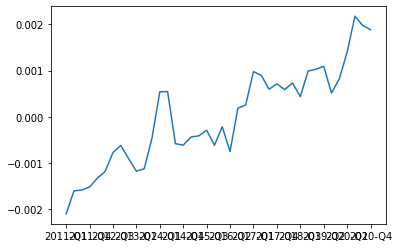

In [7]:
countries = ["Poland", "Spain", "Belgium"]

for country in countries:
    combined[f"{country}_NRCA"] = combined[f"std_{country}_t_4A2a4"] + combined[f"std_{country}_t_4A2b2"] + combined[f"std_{country}_t_4A4a1"]
    temp_mean = np.average(combined[f"{country}_NRCA"], weights=combined[f"share_{country}"])
    temp_sd = np.sqrt(np.average((combined[f"{country}_NRCA"] - temp_mean)**2, weights=combined[f"share_{country}"]))
    combined[f"std_{country}_NRCA"] = (combined[f"{country}_NRCA"] - temp_mean) / temp_sd

import matplotlib.pyplot as plt
for country in countries:
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]
    agg_country = combined.groupby(["TIME"])[f"multip_{country}_NRCA"].sum().reset_index()
    plt.plot(agg_country["TIME"], agg_country[f"multip_{country}_NRCA"])
    plt.xticks(range(0, len(agg_country), 3), agg_country["TIME"][::3])
    plt.show()